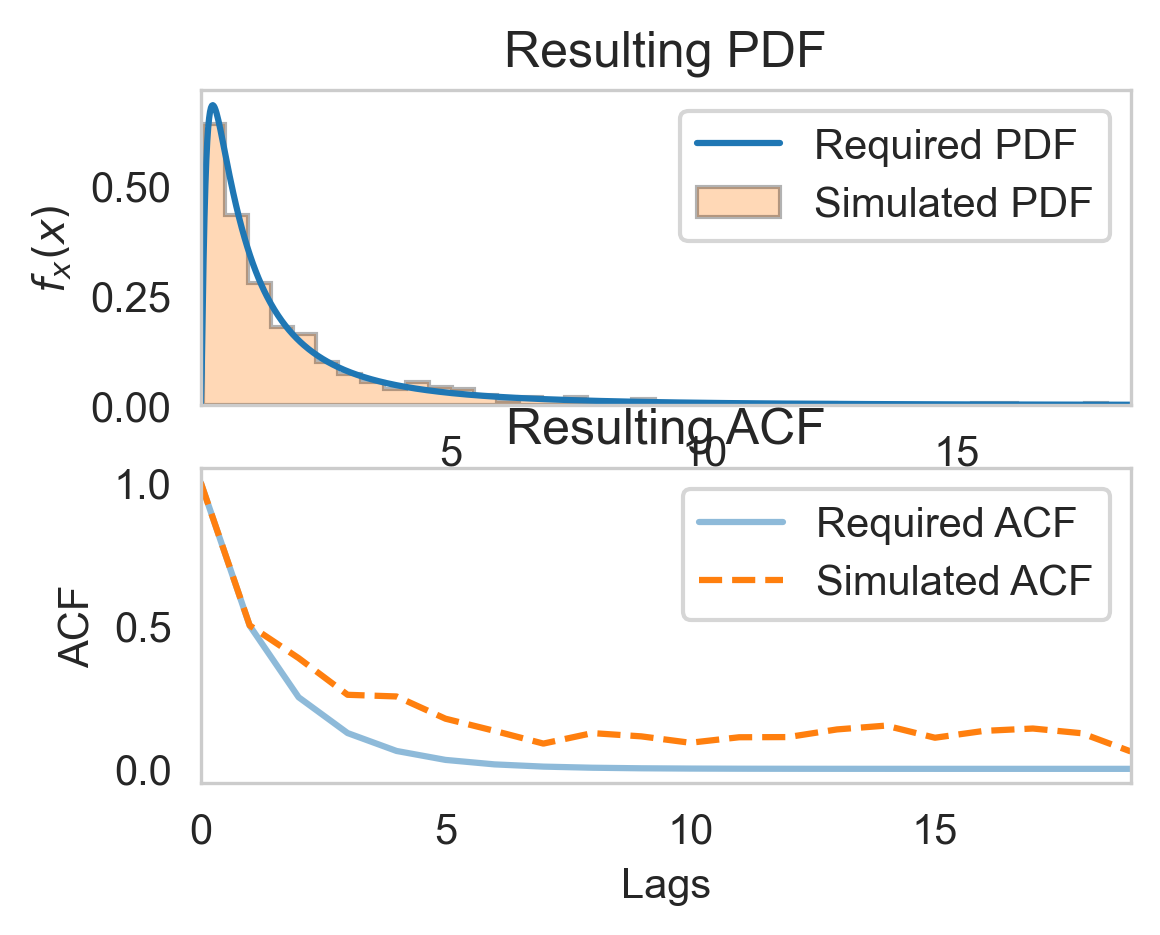

array([ 1.0667149 ,  1.88348495,  6.47059424,  4.37691396,  1.62435114,
        3.607397  ,  4.12816143,  5.00886634,  0.35472242,  0.20346983,
        0.56426237,  0.46414441,  0.41354916,  0.48485509,  0.53512871,
        0.32112648,  0.55201142,  0.51613297,  0.45222155,  0.81607976,
        0.85544199,  0.75385056,  0.50903909,  0.56708087,  0.51946328,
        0.49846037,  0.82399905,  1.30715261,  3.03868597,  3.22971027,
        1.92417944,  1.71207262,  0.56726965,  0.2809065 ,  0.19424313,
        0.34092904,  0.49108551,  0.26520042,  1.59467278,  3.95313313,
        4.21523809,  2.74646206,  2.3217239 ,  2.73160441,  0.41536617,
        1.002118  ,  0.48149256,  0.71861113,  4.14701166,  7.33219617,
        7.05572388,  2.56881528,  2.62869824,  8.19395759,  2.98643334,
        3.54586105,  6.63067921, 23.54970632,  8.61868857,  4.45591605,
        1.62465829,  1.91039124,  0.43575809,  0.65183547,  1.16874726,
        2.01131357,  1.00185936,  1.50188501,  5.82634888,  4.31

In [1]:
import pandas as pd
from generate_corr_sequence import gen_corr_sequence
import scipy.stats as st
import numpy as np

acf = 1 / (2 ** np.arange(20))

delays  = gen_corr_sequence(
    dist_obj=st.lognorm(s=1.2, loc=0.046, scale=1),
    L=500,
    target_acf=acf,
    debug=True,
)
delays

In [2]:
delays.size

500

In [3]:
acf_50 = 1 / (2 ** np.arange(5))  # 0.5 corr
acf_25 = 1 / (4 ** np.arange(5))
acf_12 = 1 / (8 ** np.arange(5))
acf_00 = np.zeros(5)
acf_00[0] = 1.0


In [4]:
acf_50

array([1.    , 0.5   , 0.25  , 0.125 , 0.0625])

In [5]:
acf_25

array([1.        , 0.25      , 0.0625    , 0.015625  , 0.00390625])

In [50]:
from collections import deque
import pandas as pd

scales = (
    0.1,
    0.2,
    0.4,
    0.8,
    1.6,
    3.2,
)
min_bound = 0.042
shape = 1.2


rows = deque()
for scale in scales:
    dist = st.lognorm(s=shape, loc=min_bound, scale=scale)
    mean, var = dist.stats()
    rows.append({
        r"$ S $": shape,
        "location": min_bound,
        "scale": scale,
        r"$\mu$": mean,
        r"$\sigma$": np.sqrt(var),
        "\num{95}\textsuperscript{th} percentile": dist.ppf(.95)
    })
    
df = pd.DataFrame(rows).set_index(["$ S $", "location", "scale"])
df

$\mu$   $\sigma$  \
$ S $ location scale                        
1.2   0.042    0.1    0.247443   0.368695   
               0.2    0.452887   0.737389   
               0.4    0.863773   1.474779   
               0.8    1.685547   2.949558   
               1.6    3.329093   5.899115   
               3.2    6.616186  11.798230   

                      \num{95}\textsuperscript{th} percentile  
$ S $ location scale                                           
1.2   0.042    0.1                                   0.761815  
               0.2                                   1.481630  
               0.4                                   2.921261  
               0.8                                   5.800522  
               1.6                                  11.559043  
               3.2                                  23.076087

In [51]:
print(
    df
    .to_latex(
        float_format="%0.2f"
    )
)

\begin{tabular}{lllrrr}
\toprule
 &  &  & $\mu$ & $\sigma$ & 
um{95}	extsuperscript{th} percentile \\
$ S $ & location & scale &  &  &  \\
\midrule
\multirow[t]{6}{*}{1.200000} & \multirow[t]{6}{*}{0.042000} & 0.100000 & 0.25 & 0.37 & 0.76 \\
 &  & 0.200000 & 0.45 & 0.74 & 1.48 \\
 &  & 0.400000 & 0.86 & 1.47 & 2.92 \\
 &  & 0.800000 & 1.69 & 2.95 & 5.80 \\
 &  & 1.600000 & 3.33 & 5.90 & 11.56 \\
 &  & 3.200000 & 6.62 & 11.80 & 23.08 \\
\cline{1-6} \cline{2-6}
\bottomrule
\end{tabular}

